# Model Build Comparisons

## microprocessor settings

In [ ]:
# Run development environment checks for gpu compute
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

In [1]:
# If GPU-compute fails run on CPU fallbacks
import os

# Force TensorFlow and XGBoost to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"

# Optional: Also limit threads to prevent CPU overload
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["TF_NUM_INTRAOP_THREADS"] = "2"
os.environ["TF_NUM_INTEROP_THREADS"] = "2"

print("Environment variables set: CUDA disabled, using CPU fallback")

Environment variables set: CUDA disabled, using CPU fallback


## load/run models

In [27]:
from tensorflow.keras.models import load_model
from transformers import TFGPT2ForSequenceClassification
import xgboost as xgb

# Load vision and XGBoost models
model1 = load_model("models/basemodel.keras")
model3 = load_model("models/model3.keras")
xgb_model = xgb.Booster()
xgb_model.load_model("models/xgb_model.json")

# Load text classification model (Model2) from Hugging Face format
model2 = TFGPT2ForSequenceClassification.from_pretrained("models/model2.keras", from_pt=False)

# Organize models
vision_models = [model1]
text_models = [model2, model3]
model_names = ["BaseModel", "Model2", "Model3"]

/usr/lib/python3/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

All the layers of TFGPT2ForSequenceClassification were initialized from the model checkpoint at models/model2.keras.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2ForSequenceClassification for predictions without further training.


In [25]:
from tensorflow.keras.models import load_model
import xgboost as xgb

model1 = load_model("models/basemodel.keras")
#model2 = load_model("models/model2.keras/tf_model.h5")
model3 = load_model("models/model3.keras")
xgb_model = xgb.Booster()
xgb_model.load_model("models/xgb_model.json")

keras_models = [model1, model2, model3]
model_names = ["BaseModel", "Model2", "Model3"]

/usr/lib/python3/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
# Load test sets samples
import random
import numpy as np
from datasets import load_dataset

# Load small test batch
USE_PERCENTAGE = 0.1

# Load dataset
dataset = load_dataset("deepcopy/MathWriting-human")
total_val_samples = int(USE_PERCENTAGE * len(dataset["val"]))
val_data = dataset["val"].select(range(total_val_samples))

latex_pool = dataset["train"]["latex"]

# Add binary_label and latex_used to val_data
def add_binary_label(example):
    if random.random() > 0.5:
        example["binary_label"] = 1
        example["latex_used"] = example["latex"]
    else:
        wrong_latex = random.choice(latex_pool)
        while wrong_latex == example["latex"]:
            wrong_latex = random.choice(latex_pool)
        example["binary_label"] = 0
        example["latex_used"] = wrong_latex
    return example

val_data = val_data.map(add_binary_label)

# Map test set true labels
y_test = np.array(val_data["binary_label"]).astype(int)
print(f"Loaded {len(y_test)} labeled test samples.")

Loaded 1567 labeled test samples.


In [29]:
# Needed to convert HF to TF dataset
"""
HF has a different framework from TF - transformers, datasets etc
"""
import tensorflow as tf

def hf_to_tf_dataset(hf_dataset, batch_size=16):
    def gen():
        for ex in hf_dataset:
            img_array = ex["image"]["array"] if isinstance(ex["image"], dict) and "array" in ex["image"] else ex["image"]
            img = tf.image.resize(tf.image.convert_image_dtype(img_array, tf.float32), (224, 224))
            label = ex["binary_label"]
            yield img, label

    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    tf_dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    tf_dataset = tf_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return tf_dataset

X_test_tf = hf_to_tf_dataset(val_data)

In [30]:
# Pull test set data from cached memory if runtime is slow
import tensorflow as tf

# Preprocess from cache image-label pairs. Build tf.data.Dataset
cached_imgs = []
cached_labels = []

for ex in val_data:
    img_array = ex["image"]["array"] if isinstance(ex["image"], dict) and "array" in ex["image"] else ex["image"]
    img = tf.image.resize(tf.image.convert_image_dtype(img_array, tf.float32), (224, 224))
    label = ex["binary_label"]
    cached_imgs.append(img)
    cached_labels.append(label)

# Convert to tf.data.Dataset
X_test_tf = tf.data.Dataset.from_tensor_slices((cached_imgs, cached_labels))
X_test_tf = X_test_tf.batch(16).prefetch(tf.data.AUTOTUNE)

print("Cached and batched test set ready.")

Cached and batched test set ready.


## model probability predictions

In [7]:
# Model1 - EfficientNetB0 (base model)
probs_dict = {}
y_probs = model1.predict(X_test_tf, verbose=1).ravel()
probs_dict["BaseModel"] = y_probs

I0000 00:00:1752821229.586194  301695 service.cc:152] XLA service 0x76b5e400e6e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752821229.586262  301695 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-07-18 06:47:09.774551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752821231.700260  301695 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step


In [31]:
# Model2 - GPT2
from transformers import TFGPT2ForSequenceClassification, GPT2TokenizerFast
import tensorflow as tf
import numpy as np

# Check GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using GPU: {physical_devices[0].name}")
    except RuntimeError as e:
        print(f"Failed to set memory growth on GPU: {e}")
else:
    print("No GPU available, using CPU fallback")
    
# Load tokenizer 
tokenizer = GPT2TokenizerFast.from_pretrained("models/model2.keras")

# Ensure LaTeX inputs are strings
latex_inputs = [str(item) for item in val_data["latex_used"]]

# Tokenize with padding and truncation
inputs = tokenizer(
    latex_inputs,
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="tf"
)

# Predict probabilities
outputs = model2(inputs)
if outputs.logits.shape[1] == 1:
    y_probs_model2 = tf.math.sigmoid(outputs.logits).numpy().ravel()
else:
    y_probs_model2 = tf.nn.softmax(outputs.logits, axis=1)[:, 1].numpy()

# Run probability predictions
probs_dict["Model2"] = y_probs_model2

No GPU available, using CPU fallback


In [32]:
probs_dict["Model2"] = y_probs_model2

In [8]:
# Model3 - Word2Vec + Model4 - XGBoost
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_latex = vectorizer.fit_transform(val_data["latex_used"])

# Model3 - Word2Vec
y_probs_m3 = model3.predict(X_latex.toarray()).ravel()
probs_dict["Model3"] = y_probs_m3

# Model4 - XGBoost
xgb_dmatrix = xgb.DMatrix(X_latex)
y_probs_xgb = xgb_model.predict(xgb_dmatrix)
probs_dict["XGBoost"] = y_probs_xgb

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step


In [9]:
y_test = np.array(val_data["binary_label"]).astype(int)

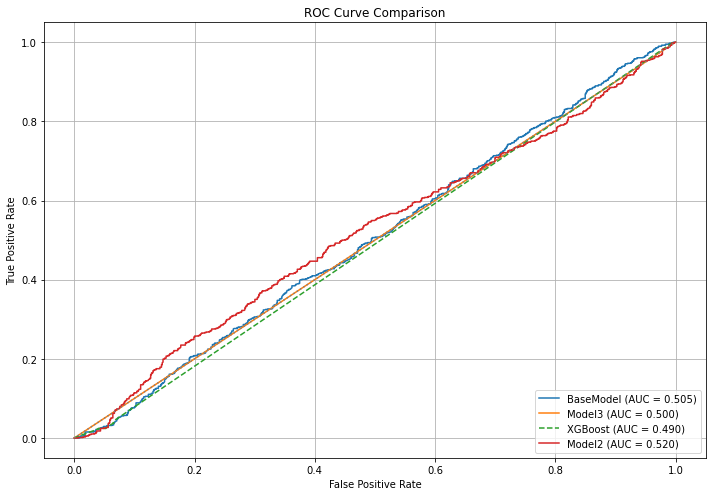

In [33]:
# Plot ROC AUC curves for models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

plt.figure(figsize=(10, 7))

for name, y_probs in probs_dict.items():
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    linestyle = '--' if name == "XGBoost" else '-'
    plt.plot(fpr, tpr, linestyle=linestyle, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## model debugging
I ran into a lot of bottlenecks. I/O in model building requires a model's input and output shapes to match exactly

In [6]:
# Inspect model input shapes to determine compatibility
models_to_check = [("BaseModel", model1), ("Model3", model3)]

for name, model in models_to_check:
    try:
        model.build()
        print(f"{name} input shape: {model.input_shape}")
    except Exception as e:
        print(f"Could not determine input shape for {name}: {e}")

Could not determine input shape for BaseModel: Functional.build() missing 1 required positional argument: 'input_shape'
Model3 input shape: (None, 64)


In [11]:
# GPT2
import os

model2_dir = "models/model2.keras"

print(f"Contents of {model2_dir}:")
for root, dirs, files in os.walk(model2_dir):
    level = root.replace(model2_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

Contents of models/model2.keras:
model2.keras/
  config.json
  merges.txt
  special_tokens_map.json
  tf_model.h5
  tokenizer_config.json
  vocab.json
  .ipynb_checkpoints/
    config-checkpoint.json


In [19]:
# GPT2
import h5py

weight_path = "models/model2.keras/tf_model.h5"
with h5py.File(weight_path, "r") as f:
    print("Top-level keys (layers):", list(f.keys()))
    for layer_name in f.keys():
        print(f"\nLayer: {layer_name}")
        layer_group = f[layer_name]
        for weight_name in layer_group.keys():
            weight = layer_group[weight_name]
            if isinstance(weight, h5py.Dataset):
                print(f"  {weight_name}: shape {weight.shape}")
            else:
                print(f"  {weight_name}: <not a dataset>")

Top-level keys (layers): ['score', 'top_level_model_weights', 'transformer']

Layer: score
  tfgpt2_for_sequence_classification_4: <not a dataset>

Layer: top_level_model_weights

Layer: transformer
  tfgpt2_for_sequence_classification_4: <not a dataset>


## Conclusions

XGBoost generalizes the best from all builds thought the features were surprising. But it looks like GPT2 has the highest ceiling which makes sense because it is the largest model. NLP and computer vision research for mathematical problem solving is challenging. This is a very granular and highly technical space in regards to the field of mathematics. To my knowledge it doesn't seem there is much research in structured tabular data and NLP or maybe even computer vision. 

There is alot of work needed to be done. Because math is a highly rigorous field of study and a cornerstone in society, it makes sense why it has not caught up yet to natural text to text NLP and computer vision respectively. These were time constrained research and builds and I would have liked to perfect the craftmanship on these builds. At the time of this writing the `version-tab` project is suboptimal due to time constraints as well. It requires a second look. Another requirement in this space I propose should be robust cybersecurity tools in the AI space. This project may be in the few that scans its GitHub repository for security vulnerabilities. This should be common practice in the field of AI. Overall, the research shows much promise for further research and development in computer vision and other domains in AI.